# Final Project - Optimizing a power generation schedule

## PIP INSTALLS AND IMPORTS

In [188]:
#Library to install
%pip install networkx seaborn pandas numpy gurobipy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [189]:
#imports
import pandas as pd   
import matplotlib.pyplot as plt  
import seaborn as sns  
import warnings
import gurobipy as gp
import numpy as np
warnings.filterwarnings("ignore")

## UNDERSTANDING THE DATA

In [190]:
df_demand = pd.read_csv('./data/demand.csv')
df_demand.head(20)

,YEAR,MONTH,DAY,HOUR,LOAD
0,2004,1,6,22,9109.936201
1,2004,1,20,2,9822.877378
2,2004,1,14,16,8026.406790
3,2004,1,26,5,7649.936201
4,2004,1,5,16,7842.877378
5,2004,1,23,12,9099.347966
6,2004,1,31,14,9044.053848
7,2004,1,30,5,8518.759731
8,2004,1,30,24,9418.171495
9,2004,1,21,14,9835.818554


In [191]:
specific_day = df_demand[(df_demand['YEAR']==2011)&(df_demand['MONTH']==7)&(df_demand['DAY']==1)] 
specific_day.sort_values(by='HOUR')

,YEAR,MONTH,DAY,HOUR,LOAD
13104,2011,7,1,1,11212.289140
13018,2011,7,1,2,10144.430320
12856,2011,7,1,3,8981.030319
13361,2011,7,1,4,8292.642084
13384,2011,7,1,5,7988.171495
13305,2011,7,1,6,7843.465613
13077,2011,7,1,7,7476.406790
12911,2011,7,1,8,7309.347966
12658,2011,7,1,9,7337.583260
13320,2011,7,1,10,7682.877378


In [192]:
demand = specific_day.set_index(['HOUR']).LOAD.to_dict()
H = set(demand.keys())

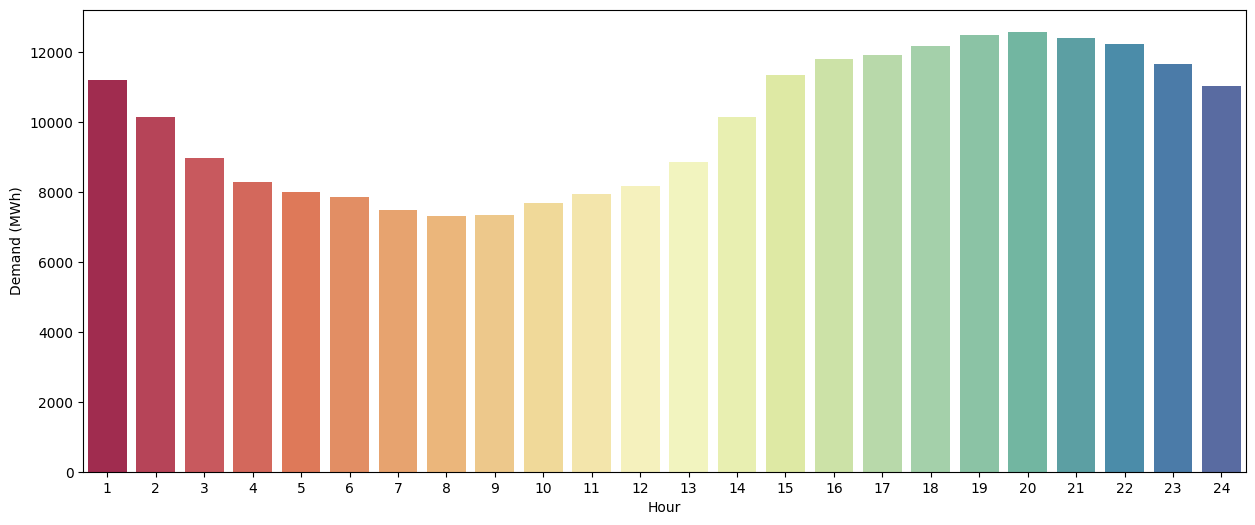

In [193]:

fig, ax = plt.subplots(figsize=(15,6)) 

# Define a palette with different colors
palette = sns.color_palette("Spectral", 24)  # 24 different colors

# Plot the barplot with the defined palette
specific_day_plot = sns.barplot(x=list(range(1,25)), y=[demand[h] for h in range(1,25)], palette=palette)
specific_day_plot.set_xticklabels(specific_day_plot.get_xticklabels())
specific_day_plot.set(xlabel='Hour', ylabel='Demand (MWh)')

plt.show()

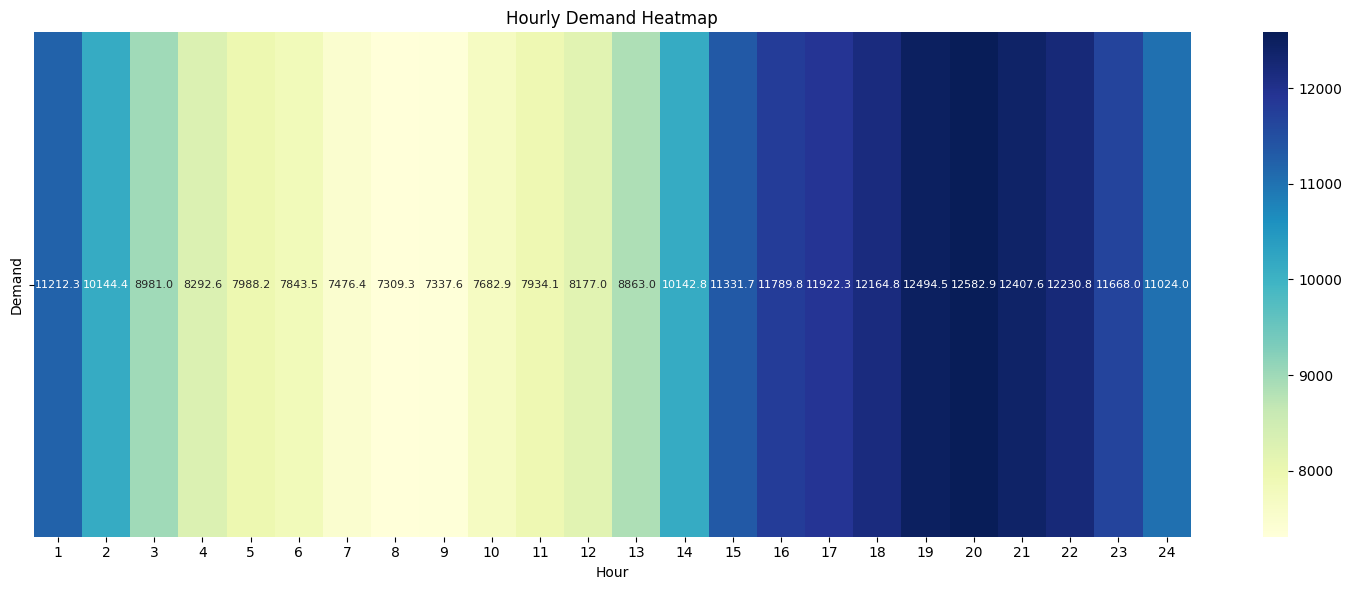

In [194]:

# Assuming 'demand' is a dictionary or series with hourly demand data
hours = list(range(1, 25))
demand_data = [demand[h] for h in range(1, 25)]

# Create the heatmap data array
data = np.array(demand_data).reshape(1, -1)

# Create the heatmap
fig, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(data, cmap="YlGnBu", cbar=True, annot=True, fmt=".1f", xticklabels=hours, yticklabels=['Demand'], annot_kws={"size": 8})

# Adjust tick parameters for better readability
ax.tick_params(axis='x', rotation=0)
ax.set_xlabel('Hour')
ax.set_title('Hourly Demand Heatmap')

# Use tight layout to avoid clipping
plt.tight_layout()
plt.show()

In [195]:
df_power_plant_infos = pd.read_csv('./data/plant_capacities.csv')
df_power_plant_infos

,Plant,PlantType,FuelType,Capacity,LAT,LON
0,Scherer,COAL,SUB,2860.11000,33.0583,-83.8072
1,Bowen,COAL,BIT,2622.37428,34.1256,-84.9192
2,Jack McDonough,COAL,BIT,430.68300,33.8244,-84.4750
3,Edwin I Hatch,NUCLEAR,NUC,1626.41228,31.9342,-82.3447
4,Vogtle,NUCLEAR,NUC,2088.69600,33.1419,-81.7565
5,OIL,OIL,BLQ,75.83748,NaN,NaN
6,BIOMASS,BIOMASS,BLQ,470.95972,NaN,NaN
7,GAS,GAS,NG,1761.30524,NaN,NaN
8,HYDRO,HYDRO,WAT,268.05618,NaN,NaN
9,OTHER COAL,OTHER COAL,BIT,4396.83212,NaN,NaN


In [196]:
P = set(df_power_plant_infos['Plant'].unique())                      
type_power_plant = df_power_plant_infos.set_index('Plant').PlantType.to_dict() 
P_N = set([i for i in P if type_power_plant[i]=='NUCLEAR'])
fuel_type = df_power_plant_infos.set_index('Plant').FuelType.to_dict()   # fuel type for each plant


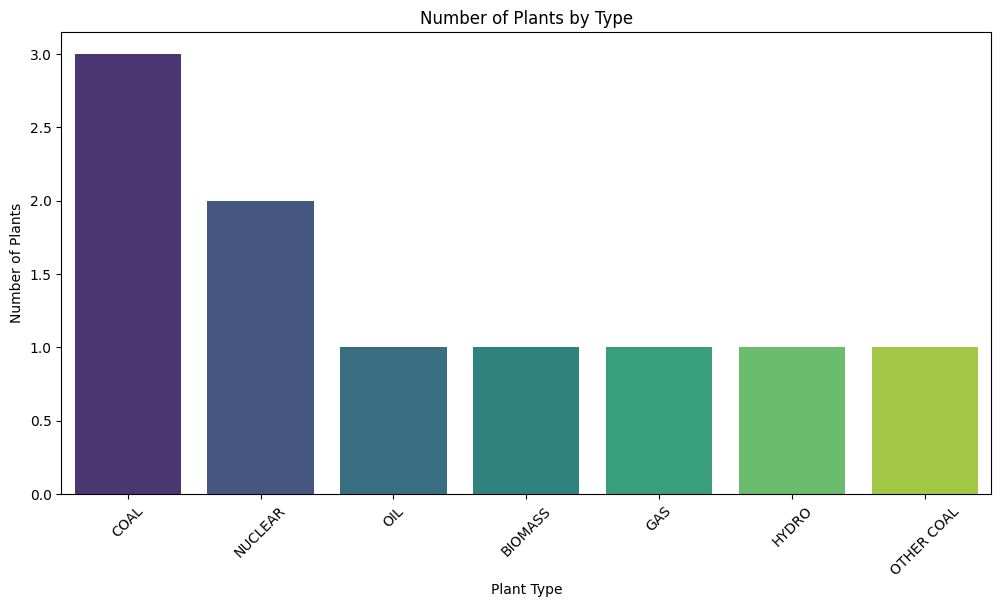

In [197]:
df_type_power_plant = pd.DataFrame(list(type_power_plant.items()), columns=['Plant', 'PlantType'])

# Count the number of plants by their types
plant_type_counts = df_type_power_plant['PlantType'].value_counts()

# Plot the histogram
plt.figure(figsize=(12, 6))
sns.barplot(x=plant_type_counts.index, y=plant_type_counts.values, palette='viridis')
plt.xlabel('Plant Type')
plt.ylabel('Number of Plants')
plt.title('Number of Plants by Type')
plt.xticks(rotation=45)
plt.show()

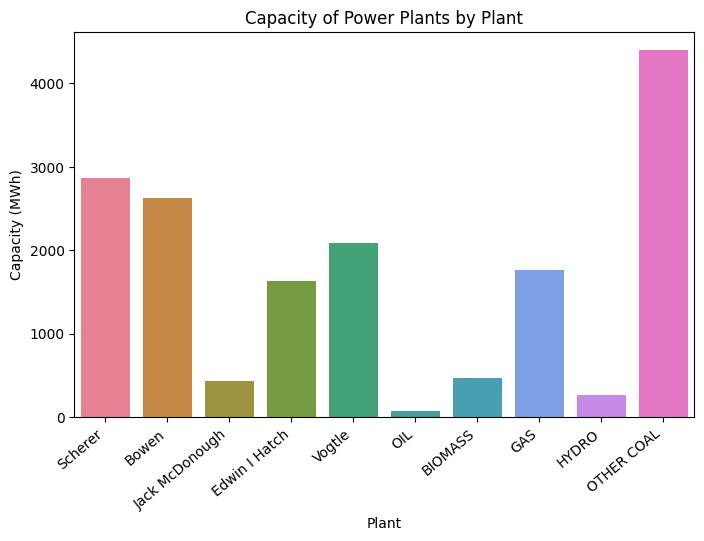

In [198]:
plants_capacity = df_power_plant_infos.set_index('Plant').Capacity.to_dict()
fig, ax = plt.subplots(figsize=(8, 5))  # Adjust the figure size if needed

# Create a barplot with a color palette
capacity_plot = sns.barplot(
    x=list(plants_capacity.keys()),
    y=[plants_capacity[k] for k in plants_capacity],
    palette='husl'
)

# Rotate the x-axis labels for better readability
capacity_plot.set_xticklabels(capacity_plot.get_xticklabels(), rotation=40, ha='right')

# Set axis labels and title
capacity_plot.set(xlabel='Plant', ylabel='Capacity (MWh)')
capacity_plot.set_title('Capacity of Power Plants by Plant')

# Display the plot
plt.show()

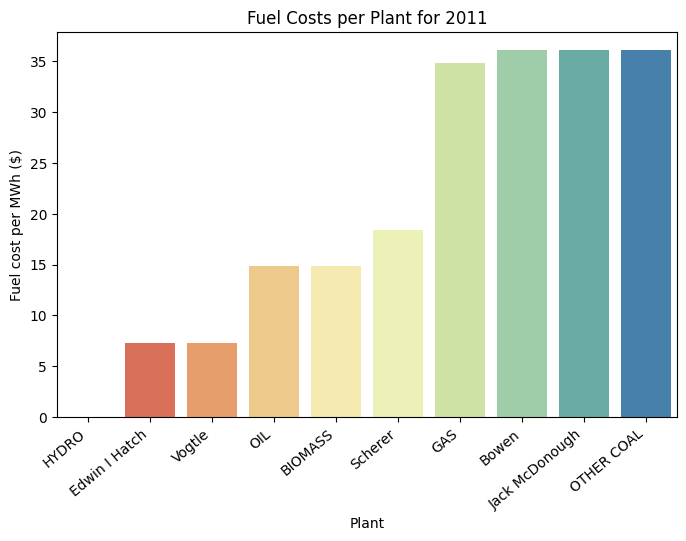

In [199]:
df_fuel_costs = pd.read_csv('./data/fuel_costs.csv')

f = {i: df_fuel_costs[df_fuel_costs['year']==2011].T.to_dict()[9][fuel_type[i]] for i in fuel_type} # dictionary of fuel cost for each plant


sorted_f = dict(sorted(f.items(), key=lambda item: item[1]))

# Plot the fuel costs
fig, ax = plt.subplots(figsize=(8, 5))  # Adjust the figure size if needed
fuelcost_plot = sns.barplot(
    x=list(sorted_f.keys()),
    y=[sorted_f[k] for k in sorted_f],
    palette='Spectral'
)

# Rotate the x-axis labels for better readability
fuelcost_plot.set_xticklabels(fuelcost_plot.get_xticklabels(), rotation=40, ha='right')

# Set axis labels and title
fuelcost_plot.set(xlabel='Plant', ylabel='Fuel cost per MWh ($)')
fuelcost_plot.set_title('Fuel Costs per Plant for 2011')

# Display the plot
plt.show()

In [200]:
df_operation_costs = pd.read_csv('./data/operating_costs.csv')
o = {i: df_operation_costs[df_operation_costs['year']==2011].T.to_dict()[9][fuel_type[i]] for i in fuel_type}

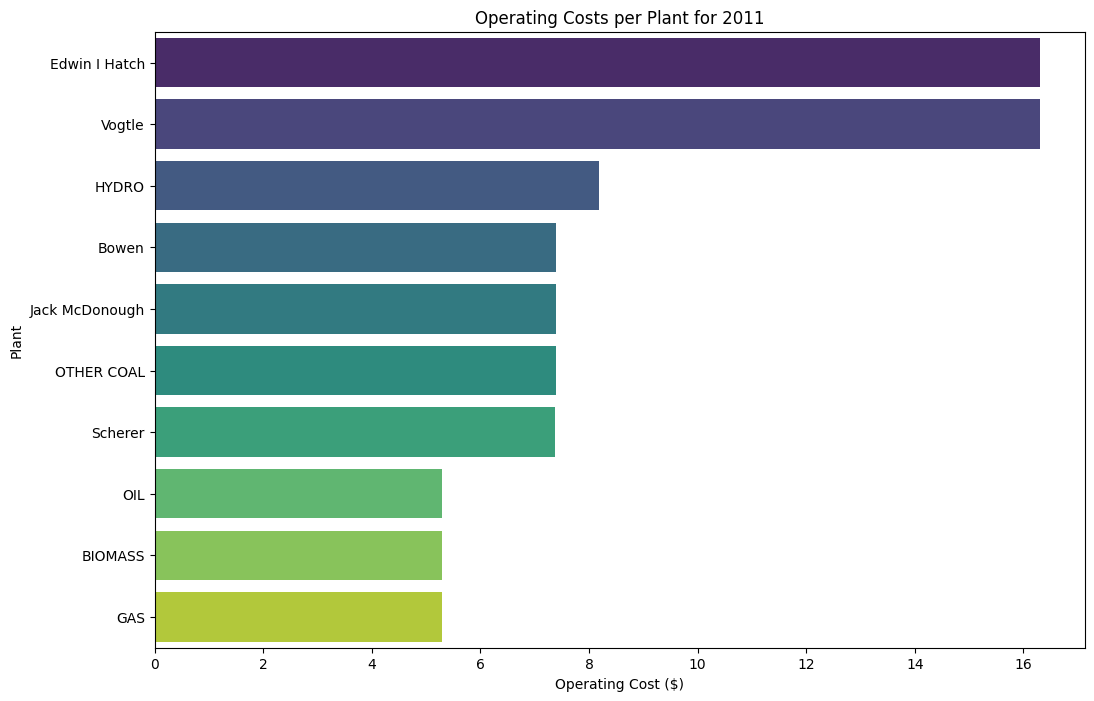

In [201]:
# Convert the dictionary to a DataFrame for easier plotting
df_o = pd.DataFrame(list(o.items()), columns=['Plant', 'Operating Cost'])

# Sort the DataFrame by operating cost in descending order for better visualization
df_o = df_o.sort_values(by='Operating Cost', ascending=False)

# Plot the horizontal bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Operating Cost', y='Plant', data=df_o, palette='viridis')
plt.xlabel('Operating Cost ($)')
plt.ylabel('Plant')
plt.title('Operating Costs per Plant for 2011')
plt.show()


In [202]:
df_startup_costs = pd.read_csv('./data/startup_costs.csv')  
s = {i: df_startup_costs[df_startup_costs['year']==2011].T.to_dict()[9][fuel_type[i]] for i in fuel_type} # operating cost/MWh (plant)
t = s.copy() 

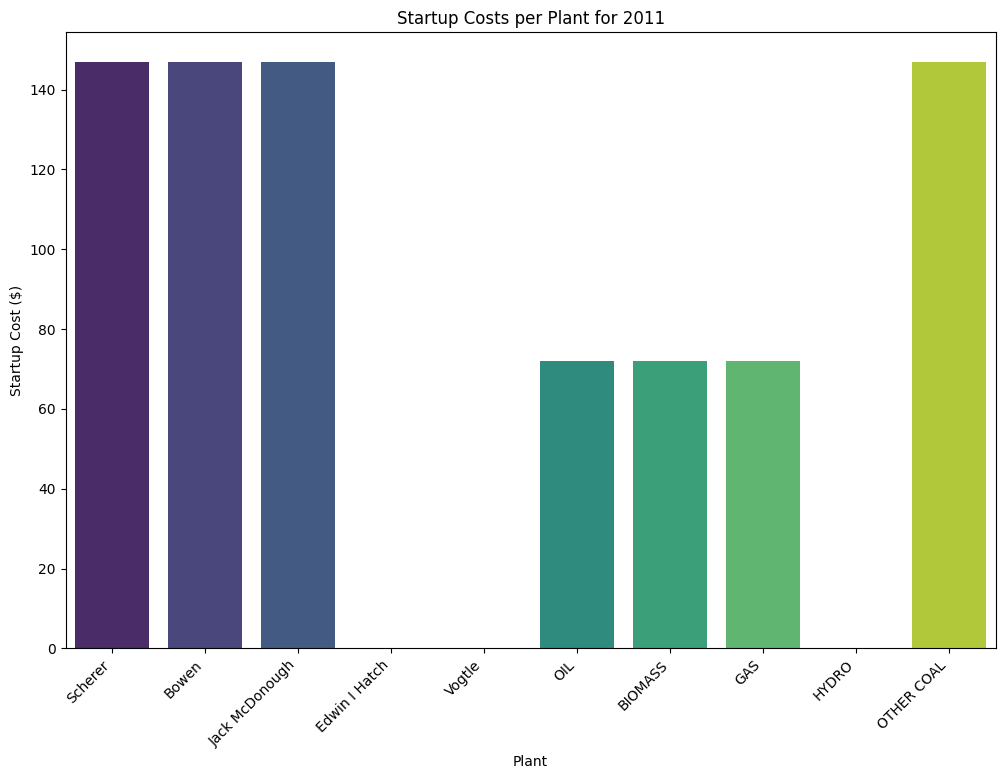

In [203]:
df_s = pd.DataFrame(list(s.items()), columns=['Plant', 'Startup Cost'])

# Plot the horizontal bar plot
plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(y='Startup Cost', x='Plant', data=df_s, palette='viridis')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Set axis labels and title
plt.ylabel('Startup Cost ($)')
plt.xlabel('Plant')
plt.title('Startup Costs per Plant for 2011')

plt.show()

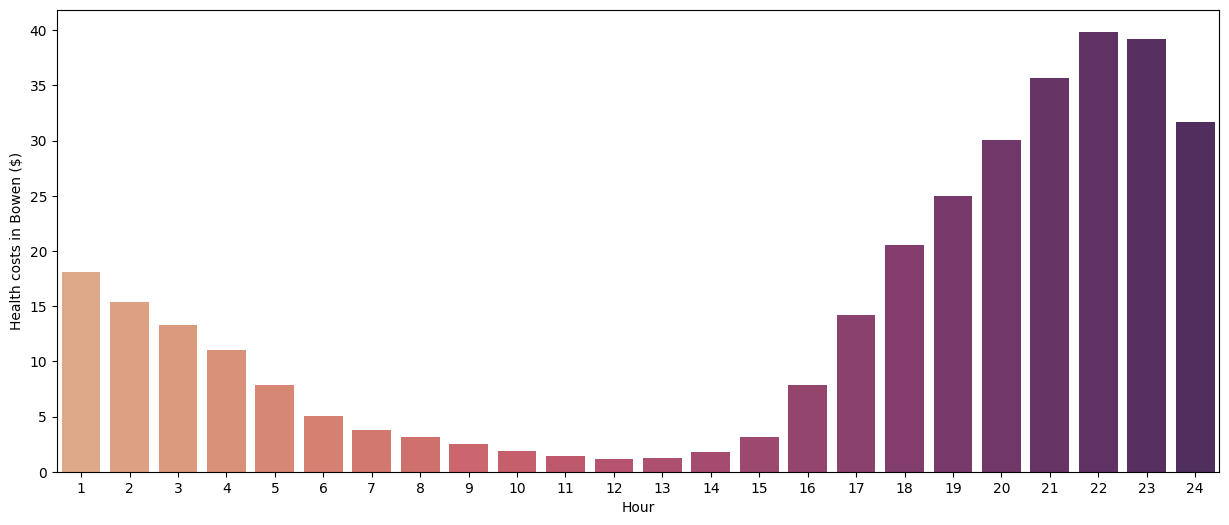

In [204]:
df_health_costs = pd.read_csv('./data/health_costs.csv')  
a = df_health_costs[(df_health_costs['Year']==2007)&(df_health_costs['Day']==1)].set_index(['Plant','Hour']).to_dict()['Cost'] # operating cost/MWh (plant)
a.update({(i,h): 0 for i in P for h in H if i not in ['Bowen','Jack McDonough','Scherer']})  

palette = sns.color_palette("flare", 24)  # 24 different colors
fig, ax = plt.subplots(figsize=(15,6)) 
healthcost_plot = sns.barplot(x=list(range(1,25)), y=[a['Bowen',h] for h in range(1,25)], palette=palette)
healthcost_plot.set_xticklabels(healthcost_plot.get_xticklabels());
healthcost_plot.set(xlabel='Hour', ylabel='Health costs in Bowen ($)');
plt.show() 

## OPTIMIZATION MODEL AND RESULTS

In [205]:
from gurobipy import GRB

# Create the model
model = gp.Model("generation-schedule-optimization")

# Define the variables
z = model.addVars(P, H, name="z", lb=0)  # power generated in each plant for each hour
u = model.addVars(P, H, name="u", vtype=GRB.BINARY, lb=0)  # is the plant on? for each plant and hour
v = model.addVars(P, H, name="v", vtype=GRB.BINARY)  # start up the plant? for each plant and hour
w = model.addVars(P, H, name="w", vtype=GRB.BINARY)  # shut down the plant? for each plant and hour

# Define the cost components
fuel_cost = gp.quicksum(f[i] * z[i, h] for i in P for h in H)
health_cost = gp.quicksum(a[i, h] * z[i, h] for i in P for h in H)
operating_cost = gp.quicksum(o[i] * u[i, h] for i in P for h in H)
startup_cost = gp.quicksum(s[i] * v[i, h] for i in P for h in H)
shutdown_cost = gp.quicksum(t[i] * w[i, h] for i in P for h in H)

# Set the objective function by summing all the costs
total_cost = fuel_cost + health_cost + operating_cost + startup_cost + shutdown_cost
model.setObjective(total_cost, sense=GRB.MINIMIZE)

# Define the constraints

#Set limits for min gen + ramp up/down
m = {i: 0.8 if i in P_N else 0.01 for i in P} # min % generation when on 
r = {i: 1 if i in ['BIOMASS','GAS','HYDRO','OIL'] else .2 if i in P_N else .25 for i in P}  # ramp up/down speed (plant)  

# Demand satisfaction constraint
model.addConstrs((gp.quicksum(z[i, h] for i in P) == demand[h]) for h in H)

# Minimum and maximum generation limits
model.addConstrs((z[i, h] >= m[i] * plants_capacity[i] * u[i, h]) for i in P for h in H)
model.addConstrs((z[i, h] <= plants_capacity[i] * u[i, h]) for i in P for h in H)

# Keep nuclear power plants always on
model.addConstrs((z[i, h] >= m[i] * plants_capacity[i]) for i in P_N for h in H)

# Ramp-up and ramp-down constraints
model.addConstrs((z[i, h] - z[i, h-1] >= -r[i] * plants_capacity[i]) for i in P for h in H if h > 1)
model.addConstrs((z[i, h] - z[i, h-1] <= r[i] * plants_capacity[i]) for i in P for h in H if h > 1)

# Startup and shutdown logic constraints
model.addConstrs((v[i, h] <= u[i, h]) for i in P for h in H)
model.addConstrs((w[i, h] <= 1 - u[i, h]) for i in P for h in H)
model.addConstrs((v[i, h] - w[i, h] == u[i, h] - u[i, h-1]) for i in P for h in H if h > 1)

# Solve the model
model.optimize()


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1722 rows, 960 columns and 4048 nonzeros
Model fingerprint: 0x29d71ae9
Variable types: 240 continuous, 720 integer (720 binary)
Coefficient statistics:
  Matrix range     [8e-01, 4e+03]
  Objective range  [5e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 601 rows and 198 columns
Presolve time: 0.02s
Presolved: 1121 rows, 762 columns, 3153 nonzeros
Variable types: 216 continuous, 546 integer (546 binary)
Found heuristic solution: objective 5181651.5204

Root relaxation: objective 4.495114e+06, 200 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap |

Power supply:


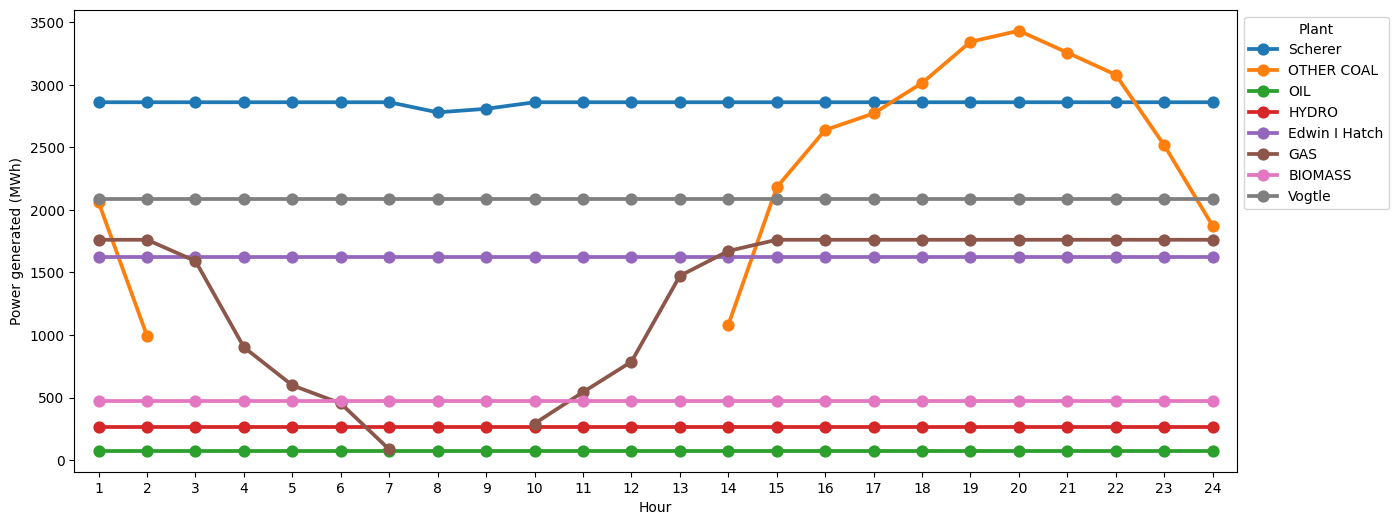

Power demand:


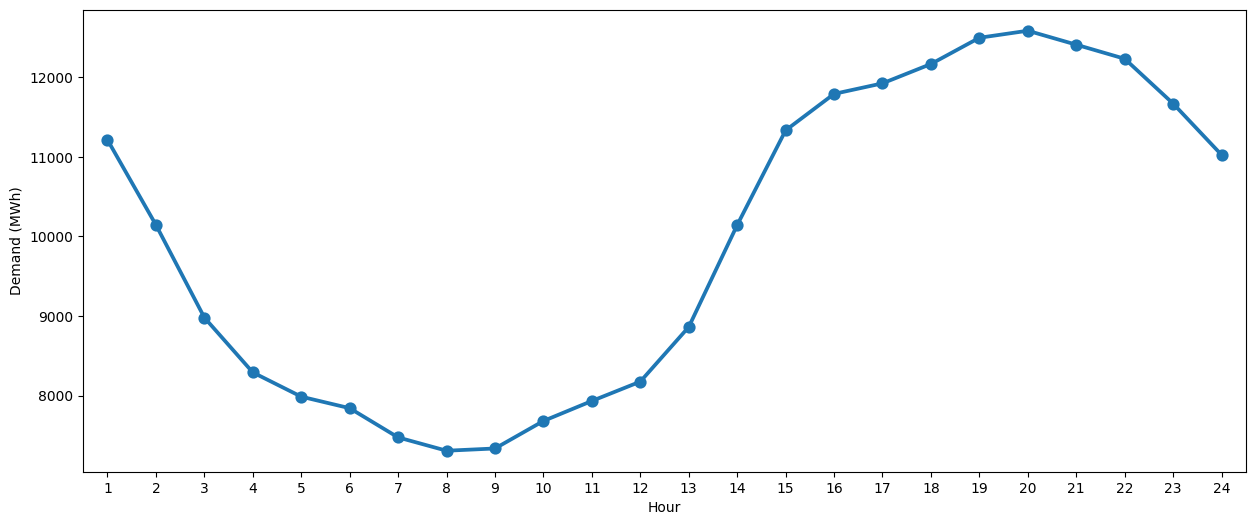

In [206]:
# Create the solution DataFrame
solution = pd.DataFrame(columns=['Hour', 'Power generated (MWh)', 'Plant'])
plant_hour_pairs = [(h, i) for i in P for h in H if z[i, h].X > 0]

# Populate the solution DataFrame
solution['Hour'] = [pair[0] for pair in plant_hour_pairs]
solution['Plant'] = [pair[1] for pair in plant_hour_pairs]
solution['Power generated (MWh)'] = [z[pair[1], pair[0]].X for pair in plant_hour_pairs]

# Plot the power supply
print("Power supply:")
fig, ax = plt.subplots(figsize=(15, 6))
sns.pointplot(data=solution, x='Hour', y='Power generated (MWh)', hue='Plant')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

# Create the demand DataFrame
demand = pd.DataFrame({
    'Hour': list(H),
    'Demand (MWh)': [demand[h] for h in H]
})

# Plot the power demand
print("Power demand:")
fig, ax = plt.subplots(figsize=(15, 6))
sns.pointplot(data=demand, x='Hour', y='Demand (MWh)')
plt.show()


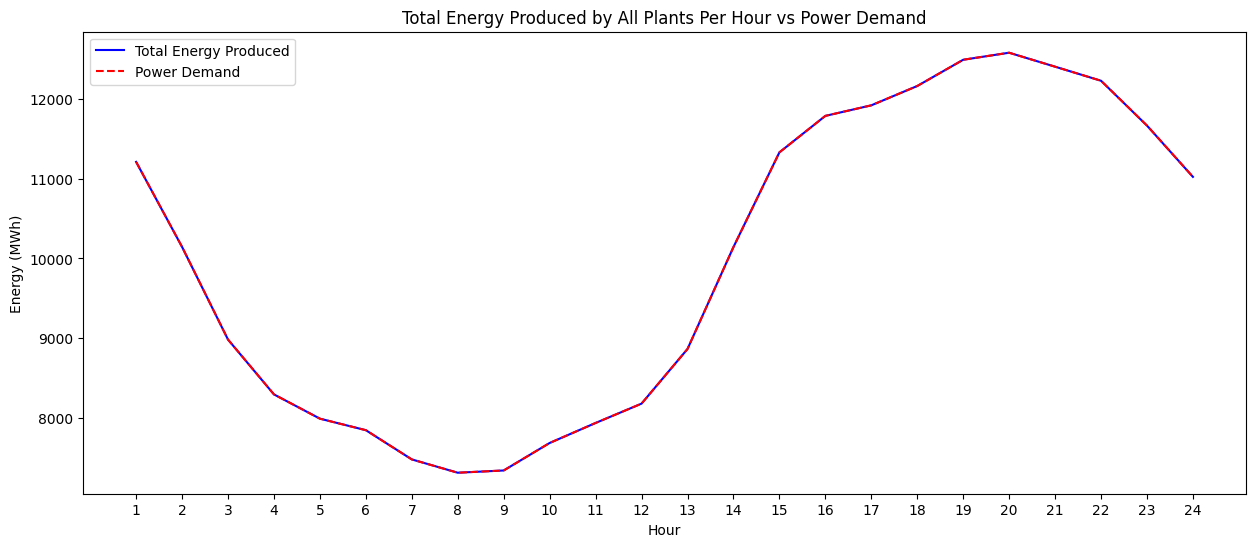

In [207]:

# Calculate total energy produced per hour
total_energy_per_hour = solution.groupby('Hour')['Power generated (MWh)'].sum()

# Ensure the x-axis includes all hours from 1 to 24
hours = range(1, 25)
total_energy_per_hour = total_energy_per_hour.reindex(hours, fill_value=0)
demand = demand.set_index('Hour').reindex(hours, fill_value=0).reset_index()

# Plotting the results
plt.figure(figsize=(15, 6))

# Line plot for total energy produced per hour
plt.plot(total_energy_per_hour.index, total_energy_per_hour.values, color='blue', label='Total Energy Produced')

# Adding the power demand to the same plot
plt.plot(demand['Hour'], demand['Demand (MWh)'], color='red', linestyle='--', label='Power Demand')

plt.title('Total Energy Produced by All Plants Per Hour vs Power Demand')
plt.xlabel('Hour')
plt.xticks(hours)  # Set x-axis ticks to be one by one from 1 to 24
plt.ylabel('Energy (MWh)')
plt.legend()

plt.show()

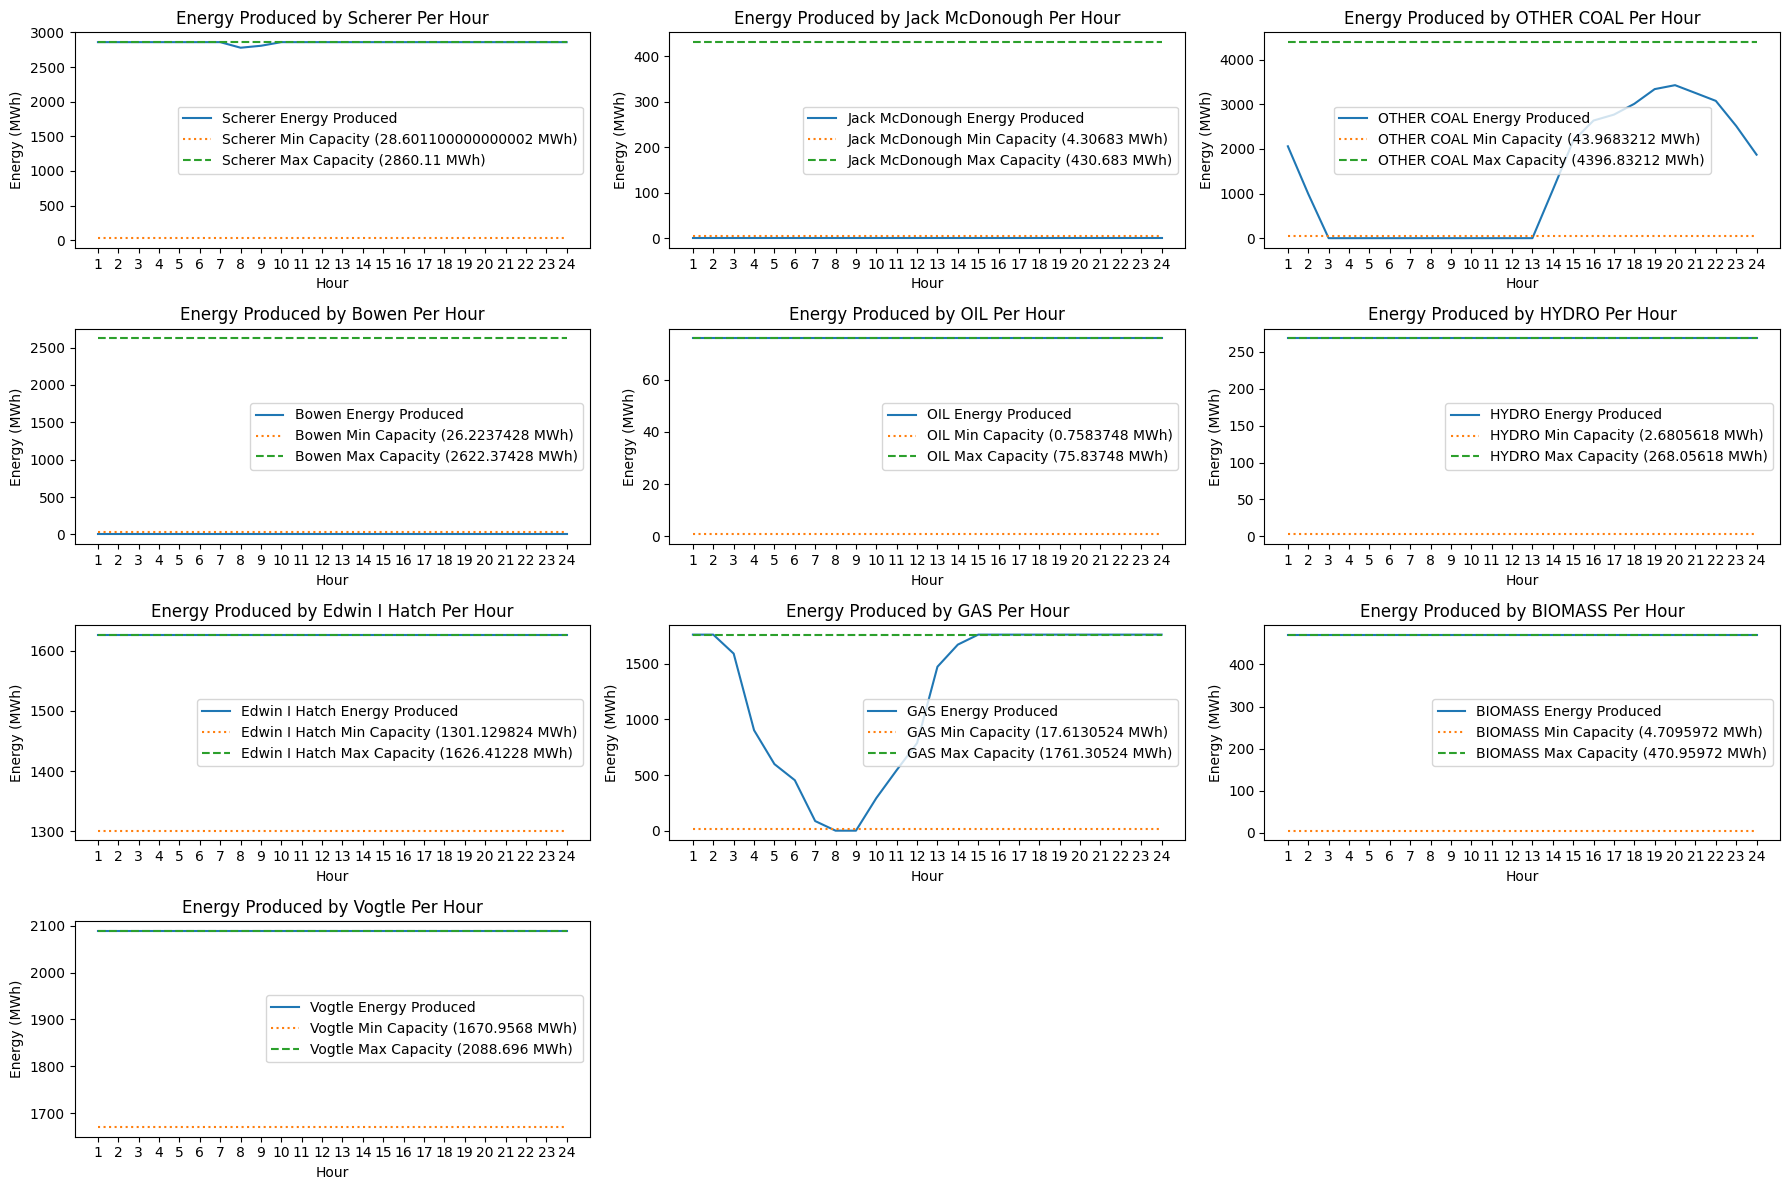

In [208]:
plant_capacities = {i: plants_capacity[i] for i in P}

# Create solution DataFrame
solution = pd.DataFrame(columns=['Hour', 'Power generated (MWh)', 'Plant'])
plant_hour_pairs = [(h, i) for i in P for h in H if z[i, h].X > 0]

solution['Hour'] = [pair[0] for pair in plant_hour_pairs]
solution['Plant'] = [pair[1] for pair in plant_hour_pairs]
solution['Power generated (MWh)'] = [z[pair[1], pair[0]].X for pair in plant_hour_pairs]

# Ensure the x-axis includes all hours from 1 to 24
hours = range(1, 25)

# Number of plants per row
plants_per_row = 3

# Create subplots
fig, axes = plt.subplots(nrows=(len(P) + plants_per_row - 1) // plants_per_row, ncols=plants_per_row, figsize=(18, 12))
axes = axes.flatten()

# Plotting the results for each plant
for idx, plant in enumerate(P):
    ax = axes[idx]
    plant_solution = solution[solution['Plant'] == plant]
    energy_per_hour = plant_solution.groupby('Hour')['Power generated (MWh)'].sum().reindex(hours, fill_value=0)
    ax.plot(energy_per_hour.index, energy_per_hour.values, label=f'{plant} Energy Produced')

    # Adding the plant's minimum and maximum operating lines
    min_operating_power = 0.01 * plant_capacities[plant] if plant not in P_N else 0.8 * plant_capacities[plant]
    max_operating_power = plant_capacities[plant]
    ax.plot(hours, [min_operating_power] * len(hours), linestyle=':', label=f'{plant} Min Capacity ({min_operating_power} MWh)')
    ax.plot(hours, [max_operating_power] * len(hours), linestyle='--', label=f'{plant} Max Capacity ({max_operating_power} MWh)')

    ax.set_title(f'Energy Produced by {plant} Per Hour')
    ax.set_xlabel('Hour')
    ax.set_xticks(hours)  # Set x-axis ticks to be one by one from 1 to 24
    ax.set_ylabel('Energy (MWh)')
    ax.legend()

# Hide any unused subplots
for i in range(len(P), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [209]:
plant_capacities = {i: plants_capacity[i] for i in P}
plant_ramp_rates = {i: r[i] for i in P}

# Create solution DataFrame
solution = pd.DataFrame(columns=['Hour', 'Power generated (MWh)', 'Plant'])
plant_hour_pairs = [(h, i) for i in P for h in H if z[i, h].X > 0]

solution['Hour'] = [pair[0] for pair in plant_hour_pairs]
solution['Plant'] = [pair[1] for pair in plant_hour_pairs]
solution['Power generated (MWh)'] = [z[pair[1], pair[0]].X for pair in plant_hour_pairs]

# Calculate the differences between consecutive hours for each plant
solution['Power_diff'] = solution.groupby('Plant')['Power generated (MWh)'].diff()

# Create a DataFrame to check constraints
check_constraints_list = []

# Ensure the x-axis includes all hours from 1 to 24
hours = range(1, 25)

# Calculate and check constraints
for plant in P:
    plant_solution = solution[solution['Plant'] == plant]
    for hour in hours:
        if hour > 1:
            power_diff = plant_solution.loc[plant_solution['Hour'] == hour, 'Power_diff']
            if not power_diff.empty:
                power_diff_value = power_diff.values[0]
                max_ramp_up = plant_ramp_rates[plant] * plant_capacities[plant]
                max_ramp_down = -plant_ramp_rates[plant] * plant_capacities[plant]
                ramp_up_ok = power_diff_value <= max_ramp_up
                ramp_down_ok = power_diff_value >= max_ramp_down
                check_constraints_list.append({
                    'Plant': plant,
                    'Hour': hour,
                    'Power_diff': power_diff_value,
                    'Max Ramp Up': max_ramp_up,
                    'Max Ramp Down': max_ramp_down,
                    'Ramp Up OK': ramp_up_ok,
                    'Ramp Down OK': ramp_down_ok
                })

check_constraints = pd.DataFrame(check_constraints_list)


# Display the table
check_constraints

,Plant,Hour,Power_diff,Max Ramp Up,Max Ramp Down,Ramp Up OK,Ramp Down OK
0,Scherer,2,0.000000e+00,715.0275,-715.0275,True,True
1,Scherer,3,-1.818989e-12,715.0275,-715.0275,True,True
2,Scherer,4,1.818989e-12,715.0275,-715.0275,True,True
3,Scherer,5,-9.094947e-13,715.0275,-715.0275,True,True
4,Scherer,6,9.094947e-13,715.0275,-715.0275,True,True
...,...,...,...,...,...,...,...
166,Vogtle,20,0.000000e+00,417.7392,-417.7392,True,True
167,Vogtle,21,0.000000e+00,417.7392,-417.7392,True,True
168,Vogtle,22,0.000000e+00,417.7392,-417.7392,True,True
169,Vogtle,23,0.000000e+00,417.7392,-417.7392,True,True


In [210]:
sol = pd.DataFrame()
plant = 'OTHER COAL'
sol['hour'] = [h for h in H]
sol['v[i,h]'] = [v[plant,h].X for h in H]
sol['w[i,h]'] = [w[plant,h].X for h in H]
sol['u[i,h]'] = [u[plant,h].X for h in H]
sol['Power Generated[i,h] (MWh)'] = [z[plant,h].X for h in H]
sol

,hour,"v[i,h]","w[i,h]","u[i,h]","Power Generated[i,h] (MWh)"
0,1,0.0,0.0,1.0,2060.91224
1,2,0.0,0.0,1.0,993.05342
2,3,0.0,1.0,0.0,0.00000
3,4,0.0,0.0,0.0,0.00000
4,5,0.0,0.0,0.0,0.00000
5,6,0.0,0.0,0.0,0.00000
6,7,0.0,0.0,0.0,0.00000
7,8,0.0,0.0,0.0,0.00000
8,9,0.0,0.0,0.0,0.00000
9,10,0.0,0.0,0.0,0.00000


In [211]:
print("Fuel costs: $",round(sum(f[i]*z[i,h].X for i in P for h in H)*10**(-6),2),"million")
print("Health costs: $",round(sum(a[i,h]*z[i,h].X for i in P for h in H)*10**(-6),2),"million")
print("Operating costs: $",round(sum(o[i]*u[i,h].X for i in P for h in H),2))
print("Start-up costs: $",round(sum(s[i]*v[i,h].X for i in P for h in H),2))
print("Start-up costs: $",round(sum(s[i]*w[i,h].X for i in P for h in H),2))

Fuel costs: $ 4.29 million
Health costs: $ 0.2 million
Operating costs: $ 1622.73
Start-up costs: $ 219.0
Start-up costs: $ 219.0
